# Installation

This cell will install contact-map and download the required files into the google colab worker. It will take up to 5 minutes.

In [ ]:
#Install contact map and dask.distributed
!pip install contact-map dask distributed


# Grab the data for this example
!curl -Lk -o 550217.zip https://ndownloader.figshare.com/articles/5550217?private_link=453b1b215cf2f9270769
!unzip -d 550217 550217.zip

# Parallel `ContactFrequency` with Dask

In principle, each frame that makes up a `ContactFrequency` can have its contact map calculated in parallel. This shows how to use [dask.distributed](https://distributed.readthedocs.io/) to do this.

This will use the same example data as the main contact maps example (data from https://figshare.com/s/453b1b215cf2f9270769). See that example, `contact_map.ipynb`, for details.

In [1]:
%matplotlib inline
# dask and distributed are extra installs
from dask.distributed import Client, LocalCluster
import contact_map

First we need to connect a client to a dask network.

Note that there are several ways to set up the dask computer network and then connect a client to it. See https://distributed.readthedocs.io/en/latest/setup.html. The approach used here creates a `LocalCluster`. Large scale simulations would need other approaches. For clusters, you can manually run a `dask-scheduler` and multiple `dask-worker` commands. By using the same `sched.json`, it is easy to have different workers in different jobs on the cluster's scheduling system.

In [2]:
c = LocalCluster()
client = Client(c)

In [3]:
# if you started on a cluster and the scheduler file is called sched.json
#client = Client(scheduler_file="./sched.json")

In [4]:
client

Client Scheduler: tcp://127.0.0.1:61226 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [5]:
%%time
freq = contact_map.DaskContactFrequency(
    client=client,
    filename="5550217/kras.xtc",
    top="5550217/kras.pdb"
)
# top must be given as keyword (passed along to mdtraj.load)

CPU times: user 954 ms, sys: 341 ms, total: 1.3 s
Wall time: 5.16 s


Note that on a single machine (shared memory) this may not improve performance. That is because the single-frame aspect of this calculation is already parallelized with OpenMP, and will therefore use all cores on the machine.

Next we check that we're still getting the same results:

In [6]:
# did it add up to give us the right number of frames?
freq.n_frames

101

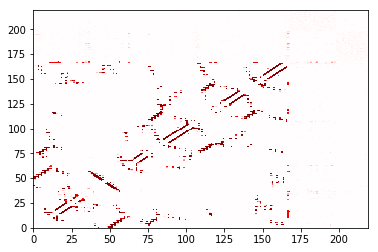

In [7]:
# do we get a familiar-looking residue map?
fig, ax = freq.residue_contacts.plot()

In [8]:
# Something like this is supposed to shut down the workers and the scheduler
# I get it to shut down workers, but not scheduler... and does it all with lots of warnings
#client.loop.add_callback(client.scheduler.retire_workers, close_workers=True)
#client.loop.add_callback(client.scheduler.terminate)
#client.run_on_scheduler(lambda dask_scheduler: dask_scheduler.loop.stop())